# Facial Landmark Detection - Intro to Deep Learning

### Import and Augment Data

In [1]:
# General imports
import pandas as pd
import numpy as np
import torch
from PIL import Image

#### Download & Import Data

In [2]:
# Download data from GitHub
!pip install wget -qU
import wget
import os.path

if not os.path.isfile("./facial-keypoints-detection.zip"):
    url = r"https://github.com/ko-redtruck/facial-landmark-detection/raw/main/facial-keypoints-detection.zip"
    wget.download(url, ".")

In [3]:
# Read training data
import zipfile

DATA_DIR = "./data"

def load_data_and_filter_from(file: str):
    data = pd.read_csv(f'{DATA_DIR}/{file}')
    data = data.dropna()
    return data

with zipfile.ZipFile("./facial-keypoints-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

training_data = load_data_and_filter_from('training.zip')
# training_data

In [4]:
# Convert data to numpy arrays

def convert_to_numpy(data: pd.DataFrame):
    X = [np.fromstring(image, dtype=np.uint8, sep=' ').reshape(96,96) for image in data["Image"]]
    X = np.reshape(X,(-1,96, 96))

    Y = np.delete(data.values,30,axis=1)
    Y = Y.reshape(-1,30).astype('float32')
    return X,Y

np_images, labels = convert_to_numpy(training_data)
np_images.shape, labels.shape

((2140, 96, 96), (2140, 30))

In [5]:
# Plot images
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_image(image: Image, labeling: np.ndarray=None):
    try:
      if isinstance(image, torch.Tensor) or isinstance(image, np.ndarray):
          image = to_pil_image(image)
    except TypeError:
      pass
    finally:
      plt.imshow(image, interpolation='nearest', cmap='gray')
      
      if labeling is not None:
          print(len(labeling))
          for i in range(0, len(labeling)-1, 2):
              plt.plot(labeling[i + 0],labeling[i + 1], marker=".", color='cyan')
      plt.show()

def plot_images(images: np.ndarray, labels: np.ndarray=None, num: int=None):
    for i in range(num if num is not None else len(images)):
        plot_image(images[i], None if labels is None else labels[i])

In [6]:
def plot_predicted_facial_landmarks(*pil_images):
  coordinates = predict_facial_landmarks(*pil_images)
  for i in range(len(pil_images)):
    plot_image(pil_images[0],coordinates[0])

def predict_facial_landmarks(*pil_images):
  preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor()
  ])

  tensor_images = [preprocess(image) for image in pil_images]
  image_batch = torch.stack(tensor_images,dim=0).to(device())
  net.eval()
  labels = net(image_batch)
  return labels.cpu().detach().numpy()


def plot_predicated_faces(data_loader, num = 10):
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.to(device())
  output = net(images)
  coordinates = output.cpu().detach().numpy()
  np_images = images.cpu().detach().numpy()

  plot_images([i.transpose(1,2,0) for i in np_images], coordinates, num)

30


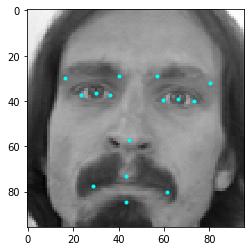

30


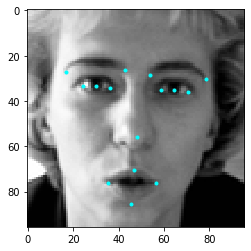

30


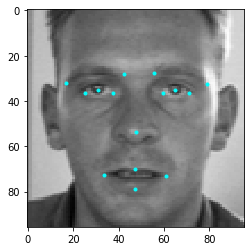

In [7]:
plot_images(np_images, labels, 3)

#### Image Preparation

In [8]:
# Transformation and augmentation of images
from torchvision import transforms
import torchvision.transforms.functional as tf
from numpy.random import randint, random

def transform_image(image: np.ndarray):
    transform = transforms.Compose([
        transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
        transforms.RandomErasing(scale=(0.01, 0.02))
    ])

    image = tf.to_tensor(image)
    image = tf.adjust_sharpness(image, 2 * random())
    return transform(image)

def random_resize_datapoint(image: torch.Tensor, labeling: np.ndarray):
    new_size = randint(image.shape[-1], 224, dtype='uint8')
    scaling = new_size / image.shape[-1]

    return tf.resize(image, [new_size, new_size]), labeling * scaling

def augment_data(images, label_list, size_factor: int=1):
    augmented_images = []
    augmented_labels = []

    for _ in range(size_factor):
        for i in range(len(images)):
            image = transform_image(images[i])
            image, labeling = random_resize_datapoint(image, label_list[i])

            augmented_images.append(image)
            augmented_labels.append(labeling)

    return augmented_images, augmented_labels

30


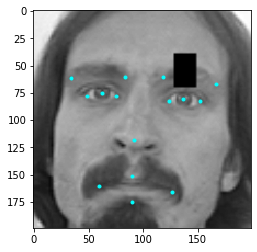

30


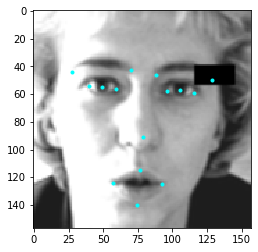

30


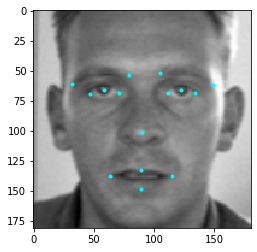

In [9]:
DATASET_AUGMENTATION_FACTOR = 5

augmented_images, augmented_labels = augment_data(np_images, labels, DATASET_AUGMENTATION_FACTOR)
plot_images(augmented_images, augmented_labels, 3)

In [10]:
# Padding images
from numpy.random import randint
from typing import Tuple

def random_pad_image_with_noise(image: torch.Tensor, new_size: Tuple[int, int], offset_x: int=0, offset_y: int=0):
    random_image = tf.to_tensor(randint(256, dtype='uint8', size=new_size))

    random_image[:, offset_y:image.shape[-2] + offset_y, offset_x:image.shape[-1] + offset_x] = image
    return random_image

def random_offset(image_dimensions, new_size: Tuple[int, int]):
    min_offset = (0, 0)
    max_offset = np.subtract(new_size, image_dimensions)

    offset_y = randint(min_offset[0], max_offset[0])
    offset_x = randint(min_offset[1], max_offset[1])
    return offset_y, offset_x

def random_pad_datapoint(image: torch.Tensor, labeling: np.ndarray, new_size: Tuple[int, int]):
    offset_y, offset_x = random_offset(image.shape[-2:], new_size)

    padded_image = random_pad_image_with_noise(image, new_size, offset_x=offset_x, offset_y=offset_y)
    adjusted_labeling = np.zeros(labeling.shape, dtype=labeling.dtype)
    adjusted_labeling[:-1:2] = labeling[:-1:2] + offset_x
    adjusted_labeling[1::2] = labeling[1::2] + offset_y

    return padded_image, adjusted_labeling

def random_pad_data(images, labels, new_size: Tuple[int, int]):
    padded_images = []
    adjusted_labels = []

    for i in range(len(images)):
        image, labeling = random_pad_datapoint(image=images[i], labeling=labels[i], new_size=new_size)
        padded_images.append(image)
        adjusted_labels.append(labeling)

    return torch.stack(padded_images), adjusted_labels

30


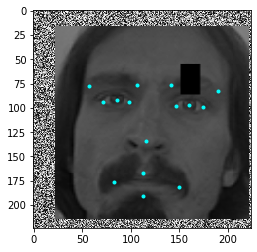

30


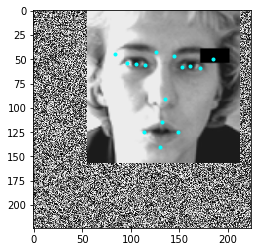

30


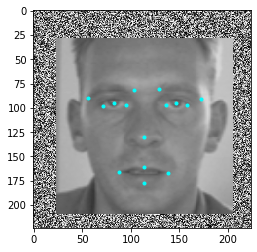

In [11]:
padded_images, final_labels = random_pad_data(augmented_images, augmented_labels, (224, 224))
plot_images(padded_images, final_labels, 3)

30


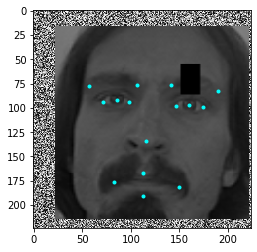

30


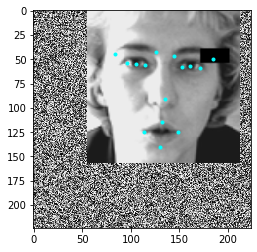

30


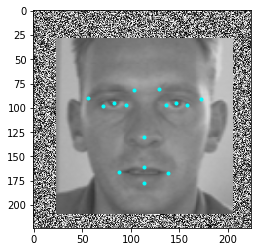

torch.Size([10700, 3, 224, 224])

In [12]:
# Transform images to RGB
final_images = torch.zeros((len(padded_images), 3, 224, 224))
final_images[:, :] = padded_images[:]

plot_images(final_images, final_labels, 3)
final_images.shape

### Training
#### Set up wandb & Cuda device

In [13]:
#Instantiating CUDA device
import torch

def device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device()

device(type='cuda', index=0)

In [14]:
!pip install wandb -qU
import wandb

wandb.login()

wandb: Currently logged in as: leonardhorns. Use `wandb login --relogin` to force relogin


True

#### Define model and parameters for run

In [15]:
NET = "ResNet18"
FC_LAYER = "Lin-ReLu-Lin"
OPTIMIZER = "AdamW"
LOSS = "MSE"
LR_SCHEDULER = "Cyclic"
EPOCHS = 3000
BATCH_SIZE = 300
MAX_LR = 0.01
MOMENTUM = 0.9 # SGD
WEIGHT_DECAY = 0.01

In [16]:
# Define parameter mappings
from torchvision.models import resnet18
from torch.optim import Adam, AdamW
from torch import nn

def add_fc(net, layer):
    net.fc = layer
    return net

fc_layers = {
    "Lin-ReLu-Lin": nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,30)
    ),
    "Linear": nn.Linear(512, 30)
}

networks = {
    "ResNet18": add_fc(resnet18(pretrained=True), fc_layers[FC_LAYER])
}

optimizers = {
    "Adam": Adam(networks[NET].parameters(), weight_decay=WEIGHT_DECAY),
    "AdamW" : AdamW(networks[NET].parameters(), weight_decay=WEIGHT_DECAY)

}

loss_functions = {
    "MSE": nn.MSELoss()
}

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Set up Training

In [17]:
import sys
net = networks[NET].to(device())
optimizer = optimizers[OPTIMIZER]
loss_function = loss_functions[LOSS]
num_workers = 0 if sys.platform.startswith('win') else 2

In [18]:
# Define data loaders
from torch.utils.data import DataLoader, random_split

def get_data_loaders(images, labels, batch_size, test_data_split=0.1, num_workers=2):
    dataset = list(zip(images, labels))
    training_data_size = int(len(dataset) * (1-test_data_split))
    train, test = random_split(dataset, [training_data_size, len(dataset) - training_data_size])

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test, batch_size=batch_size, num_workers=num_workers)
    return train_loader,test_loader

In [19]:
train_loader, test_loader = get_data_loaders(final_images, final_labels, batch_size=BATCH_SIZE, test_data_split=0.15, num_workers=num_workers)

In [20]:
from torch.optim.lr_scheduler import OneCycleLR, CyclicLR

schedulers = {
    "OneCycle": OneCycleLR(optimizer, max_lr=MAX_LR, steps_per_epoch=len(train_loader), epochs=EPOCHS),
    "Cyclic": CyclicLR(optimizer, base_lr=0.0001, max_lr=MAX_LR, mode='triangular2', cycle_momentum=False)
}
scheduler = schedulers[LR_SCHEDULER]

### Testing

In [23]:
# open test images
from torchvision.transforms.functional import to_tensor

test_image = to_tensor(Image.open('test-photo-konsti.png'))
test_image_leo = to_tensor(Image.open('test-webcam-leo.png'))

In [25]:
# plot predictions
from torchvision.transforms.functional import to_tensor

def plot_predictions_on_image(net, images, true_labels=None):
    try:
        inputs = to_tensor(images)
    except TypeError:
        inputs = images
        
    net.eval()
    with torch.no_grad():
      predicted_labels = net(inputs.to(device())).cpu()

    for i in range(len(images)):
        plt.scatter(predicted_labels[i][:-1:2], predicted_labels[i][1::2], marker=".", color='magenta')
        plot_image(images[i], None if true_labels is None else true_labels[i])

#### Training

In [26]:
# Define training and testing steps

def compute_loss(inputs, labels, net, loss_function):
    outputs = net(inputs.to(device()))
    labels = labels.to(device())

    return loss_function(outputs, labels)

wandb: Currently logged in as: leonardhorns (leo-team). Use `wandb login --relogin` to force relogin


epoch 1, train loss 13377.4677734375, test loss 12083.6171875, learning rate 0.0002534499999999985
epoch 2, train loss 10215.177734375, test loss 5772.7001953125, learning rate 0.0004069000000000014
epoch 3, train loss 2667.87158203125, test loss 1110.07470703125, learning rate 0.0005603499999999999
epoch 4, train loss 453.1799011230469, test loss 502.2402038574219, learning rate 0.0007137999999999985


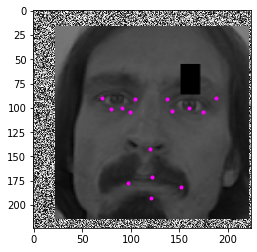

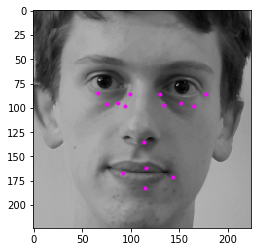

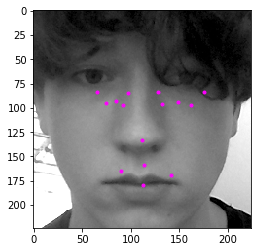

epoch 5, train loss 356.4533996582031, test loss 320.76239013671875, learning rate 0.0008672500000000014
epoch 6, train loss 324.15753173828125, test loss 315.671630859375, learning rate 0.0010206999999999998
epoch 7, train loss 321.71063232421875, test loss 303.8423156738281, learning rate 0.0011741499999999984
epoch 8, train loss 305.8247375488281, test loss 281.8210754394531, learning rate 0.0013276000000000013
epoch 9, train loss 283.4815979003906, test loss 257.67779541015625, learning rate 0.0014810499999999998


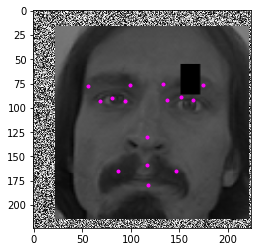

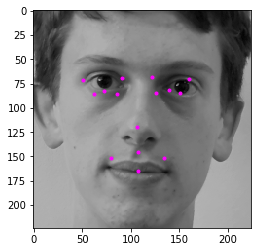

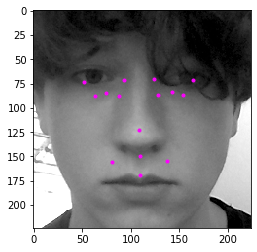

epoch 10, train loss 226.16812133789062, test loss 188.9634246826172, learning rate 0.0016344999999999982
epoch 11, train loss 104.8897476196289, test loss 106.58797454833984, learning rate 0.001787950000000001
epoch 12, train loss 43.800865173339844, test loss 30.127408981323242, learning rate 0.0019413999999999996
epoch 13, train loss 30.62253761291504, test loss 24.301544189453125, learning rate 0.0020948500000000023
epoch 14, train loss 28.39063262939453, test loss 25.012039184570312, learning rate 0.002248300000000001


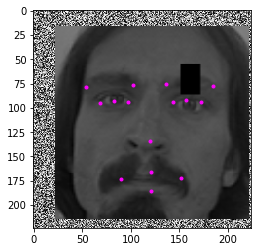

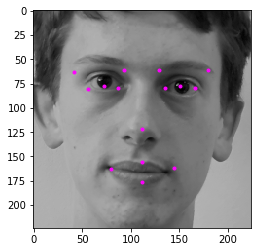

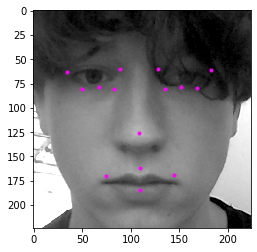

epoch 15, train loss 24.866836547851562, test loss 27.667142868041992, learning rate 0.0024017499999999994
epoch 16, train loss 24.468841552734375, test loss 27.651256561279297, learning rate 0.0025552000000000023
epoch 17, train loss 21.039390563964844, test loss 19.385173797607422, learning rate 0.002708650000000001
epoch 18, train loss 21.710819244384766, test loss 19.647701263427734, learning rate 0.0028620999999999994
epoch 19, train loss 21.130617141723633, test loss 19.022125244140625, learning rate 0.0030155500000000023


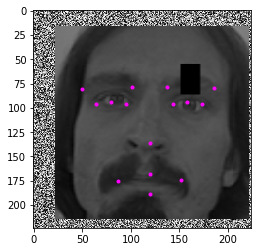

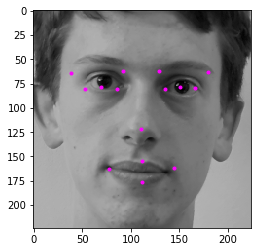

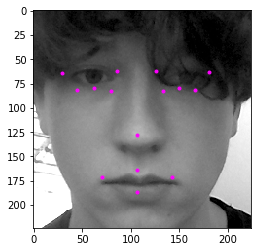

epoch 20, train loss 20.77958106994629, test loss 22.086414337158203, learning rate 0.003169000000000001
epoch 21, train loss 21.73100471496582, test loss 19.26786994934082, learning rate 0.003322449999999999
epoch 22, train loss 21.872325897216797, test loss 19.284372329711914, learning rate 0.003475900000000002
epoch 23, train loss 20.286041259765625, test loss 21.42782211303711, learning rate 0.0036293500000000004
epoch 24, train loss 21.29279899597168, test loss 21.02553939819336, learning rate 0.003782799999999999


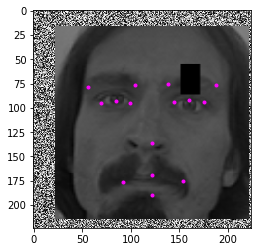

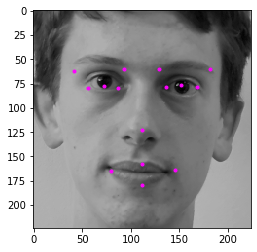

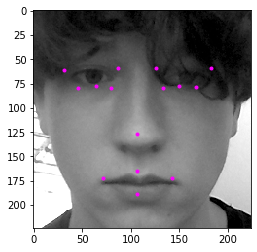

epoch 25, train loss 23.955013275146484, test loss 20.017568588256836, learning rate 0.003936250000000002
epoch 26, train loss 23.479097366333008, test loss 28.42425537109375, learning rate 0.004089700000000001
epoch 27, train loss 21.647680282592773, test loss 22.099876403808594, learning rate 0.004243149999999999
epoch 28, train loss 21.982267379760742, test loss 19.61301040649414, learning rate 0.004396600000000002
epoch 29, train loss 22.518062591552734, test loss 19.48480987548828, learning rate 0.004550050000000001


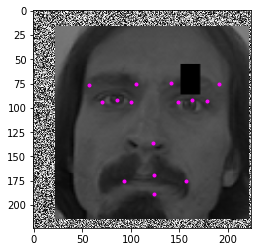

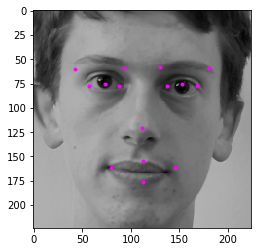

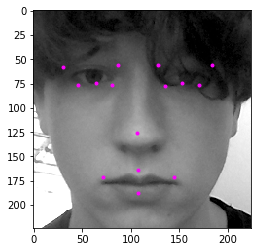

epoch 30, train loss 21.494644165039062, test loss 24.935203552246094, learning rate 0.004703499999999999
epoch 31, train loss 21.578977584838867, test loss 22.33501434326172, learning rate 0.004856950000000002


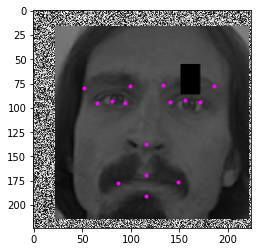

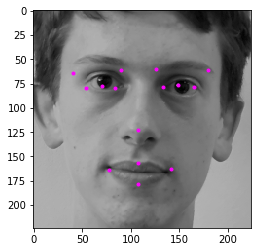

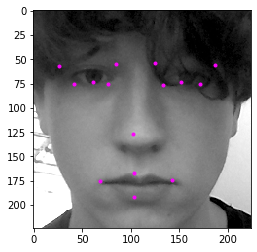

epoch 40, train loss 23.16686248779297, test loss 23.340362548828125, learning rate 0.006238000000000002


In [ ]:
# Init wandb tracking
wandb.init(project="facial-landmark-detection", entity="leo-team", config={"net": NET, "optimizer": OPTIMIZER, "lr_scheduler": LR_SCHEDULER, "final_layer": FC_LAYER, "epochs": EPOCHS, "batch_size": BATCH_SIZE, "max_lr": MAX_LR, "weight decay" : WEIGHT_DECAY, "dataset_multiplier" : DATASET_AUGMENTATION_FACTOR})

# loop over the dataset multiple times
for epoch in range(EPOCHS): 
    # train model
    train_loss = 0.
    net.train()
    for inputs, labels in train_loader:
        loss = compute_loss(inputs, labels, net, loss_function)
        train_loss += loss

        # optimize model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    # average loss
    train_loss /= len(train_loader)
    
    current_learning_rate = scheduler.get_last_lr()[0]

    # test model
    net.eval()
    with torch.no_grad():
      test_loss = 0.
      for inputs, labels in test_loader:
        test_loss += compute_loss(inputs, labels, net, loss_function)

      test_loss /= len(test_loader)
    
    if (epoch+1)%5==0:
        plot_predictions_on_image(net, torch.stack([final_images[0], test_image, test_image_leo]))
    #   plot_predicted_facial_landmarks(test_image)
    #   plot_predicted_facial_landmarks(test_image_leo)
    #   plot_predicated_faces(test_loader,3)

    # log error
    print('epoch {}, train loss {}, test loss {}, learning rate {}'.format(epoch+1, train_loss, test_loss, current_learning_rate))
    wandb.log({
      "train_loss": train_loss,
      "test_loss": test_loss,
      "learning_rate": current_learning_rate
    })

### Test Model

In [ ]:
test_images, test_labels = next(iter(test_loader))

plot_predictions_on_image(net, test_images[0:5], test_labels[0:5])